In [ ]:
import tensorflow as tf
from tensorflow import keras as keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# check tensorflow and keras versions
print(tf.__version__)
print(keras.__version__)

2.6.0
2.6.0


In [ ]:
# set plot parameters
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
# load the  dataset
file = tf.keras.utils
raw_df = pd.read_csv('/content/creditcard.csv')
raw_df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# how much are two classes are imbalanced?
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print(f'Examples:\n    Total: {total}\n    Positive: {pos} ({100*pos/total:.2f}% of total)')

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)


In [ ]:
# clean, split and normalize the data
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [ ]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'Negative distribution')

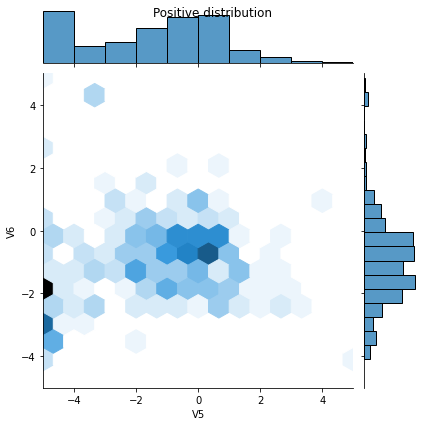

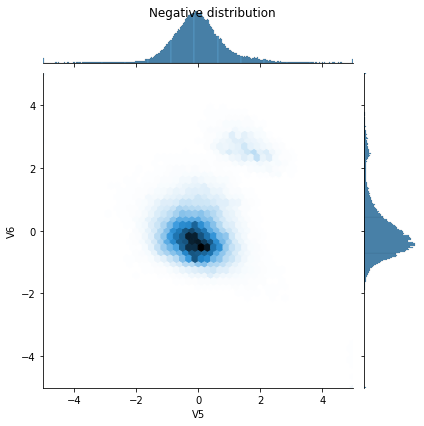

In [ ]:
# let's look at the data distribution
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Negative distribution")

In [ ]:
# define the model and metrics
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'), 
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.AUC(name='prc', curve='PR')]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
                            keras.layers.Dropout(0.5),
                            keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.BinaryCrossentropy(), metrics=metrics)

  return model

In [ ]:
# build the model
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1, patience=10,
                                                  mode='max', restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                480       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set the correct initial bias
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3106


In [ ]:
# the correct bias 
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00287285],
       [0.00578105],
       [0.00331715],
       [0.00284687],
       [0.00476366],
       [0.00395465],
       [0.00699902],
       [0.00282729],
       [0.00201675],
       [0.0039292 ]], dtype=float32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0270


In [ ]:
# save initial model parameters
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
# confirm that the bias fix helps
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE,
                              epochs=20, validation_data=(val_features, val_labels), verbose=1)

Epoch 1/20
90/90 [==============================] - 3s 14ms/step - loss: 1.0302 - tp: 163.0000 - fp: 129186.0000 - tn: 416661.0000 - fn: 818.0000 - accuracy: 0.7623 - precision: 0.0013 - recall: 0.1662 - auc: 0.4214 - prc: 0.0016 - val_loss: 0.6566 - val_tp: 6.0000 - val_fp: 17449.0000 - val_tn: 28043.0000 - val_fn: 71.0000 - val_accuracy: 0.6155 - val_precision: 3.4374e-04 - val_recall: 0.0779 - val_auc: 0.1109 - val_prc: 0.0011
Epoch 2/20
90/90 [==============================] - 0s 4ms/step - loss: 0.5552 - tp: 51.0000 - fp: 51553.0000 - tn: 130396.0000 - fn: 276.0000 - accuracy: 0.7157 - precision: 9.8830e-04 - recall: 0.1560 - auc: 0.2445 - prc: 0.0014 - val_loss: 0.3596 - val_tp: 1.0000 - val_fp: 2363.0000 - val_tn: 43129.0000 - val_fn: 76.0000 - val_accuracy: 0.9465 - val_precision: 4.2301e-04 - val_recall: 0.0130 - val_auc: 0.1306 - val_prc: 0.0012
Epoch 3/20
90/90 [==============================] - 0s 4ms/step - loss: 0.3548 - tp: 41.0000 - fp: 16295.0000 - tn: 165654.0000 - fn

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE,
                                 epochs=20, validation_data=(val_features, val_labels), verbose=1)

Epoch 1/20
90/90 [==============================] - 3s 14ms/step - loss: 0.0221 - tp: 76.0000 - fp: 377.0000 - tn: 227064.0000 - fn: 328.0000 - accuracy: 0.9969 - precision: 0.1678 - recall: 0.1881 - auc: 0.6600 - prc: 0.0437 - val_loss: 0.0104 - val_tp: 2.0000 - val_fp: 4.0000 - val_tn: 45488.0000 - val_fn: 75.0000 - val_accuracy: 0.9983 - val_precision: 0.3333 - val_recall: 0.0260 - val_auc: 0.7960 - val_prc: 0.1695
Epoch 2/20
90/90 [==============================] - 0s 4ms/step - loss: 0.0104 - tp: 84.0000 - fp: 46.0000 - tn: 181903.0000 - fn: 243.0000 - accuracy: 0.9984 - precision: 0.6462 - recall: 0.2569 - auc: 0.8353 - prc: 0.3104 - val_loss: 0.0066 - val_tp: 32.0000 - val_fp: 9.0000 - val_tn: 45483.0000 - val_fn: 45.0000 - val_accuracy: 0.9988 - val_precision: 0.7805 - val_recall: 0.4156 - val_auc: 0.9225 - val_prc: 0.6004
Epoch 3/20
90/90 [==============================] - 0s 4ms/step - loss: 0.0080 - tp: 136.0000 - fp: 32.0000 - tn: 181917.0000 - fn: 191.0000 - accuracy: 0.99

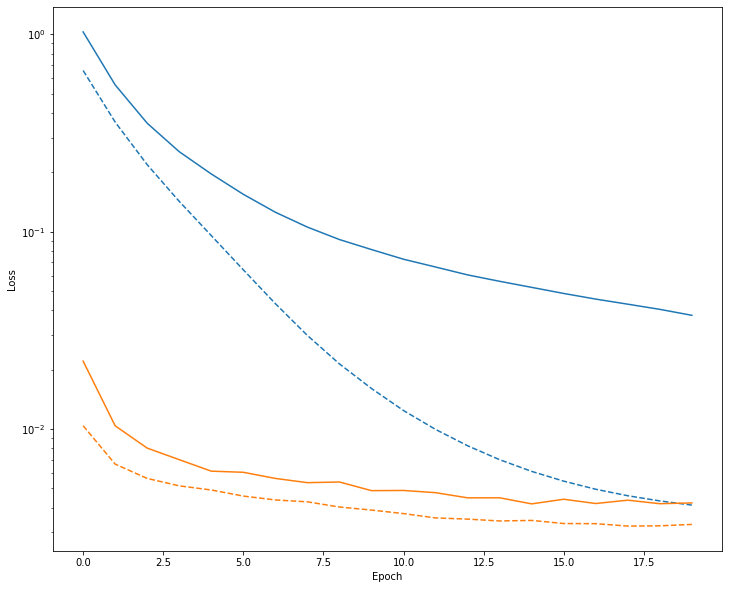

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label, linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
# train
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE,
                             epochs=EPOCHS, callbacks=[early_stopping],
                             validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 3s 14ms/step - loss: 0.0219 - tp: 83.0000 - fp: 354.0000 - tn: 227087.0000 - fn: 321.0000 - accuracy: 0.9970 - precision: 0.1899 - recall: 0.2054 - auc: 0.6650 - prc: 0.0924 - val_loss: 0.0099 - val_tp: 10.0000 - val_fp: 5.0000 - val_tn: 45487.0000 - val_fn: 67.0000 - val_accuracy: 0.9984 - val_precision: 0.6667 - val_recall: 0.1299 - val_auc: 0.8511 - val_prc: 0.2244
Epoch 2/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0101 - tp: 88.0000 - fp: 55.0000 - tn: 181894.0000 - fn: 239.0000 - accuracy: 0.9984 - precision: 0.6154 - recall: 0.2691 - auc: 0.8500 - prc: 0.3281 - val_loss: 0.0066 - val_tp: 31.0000 - val_fp: 9.0000 - val_tn: 45483.0000 - val_fn: 46.0000 - val_accuracy: 0.9988 - val_precision: 0.7750 - val_recall: 0.4026 - val_auc: 0.9227 - val_prc: 0.6102
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0075 - tp: 141.0000 - fp: 35.0000 - tn: 181914.0000 - fn: 186.0000 - accuracy: 

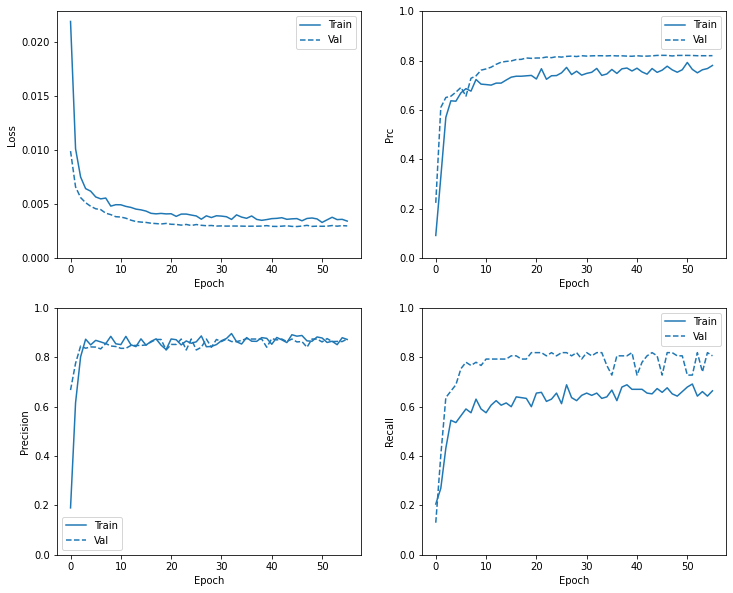

In [ ]:
# check training history
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


plot_metrics(baseline_history)

In [ ]:
# evaluate metrics
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.002535433042794466
tp :  67.0
fp :  4.0
tn :  56870.0
fn :  21.0
accuracy :  0.9995611310005188
precision :  0.9436619877815247
recall :  0.7613636255264282
auc :  0.942862868309021
prc :  0.835157036781311

Legitimate Transactions Detected (True Negatives):  56870
Legitimate Transactions Incorrectly Detected (False Positives):  4
Fraudulent Transactions Missed (False Negatives):  21
Fraudulent Transactions Detected (True Positives):  67
Total Fraudulent Transactions:  88


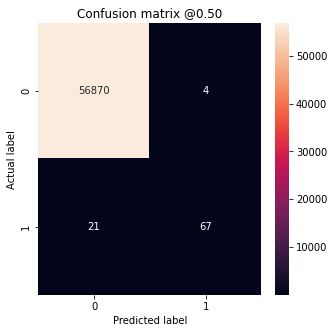

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

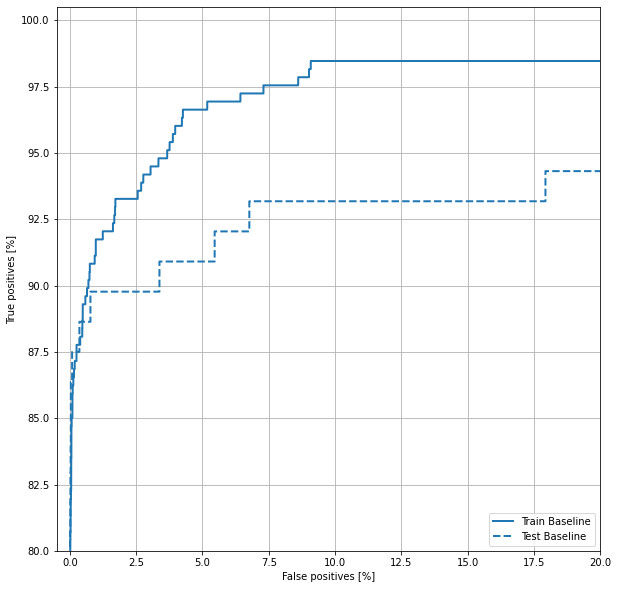

In [ ]:
# roc
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

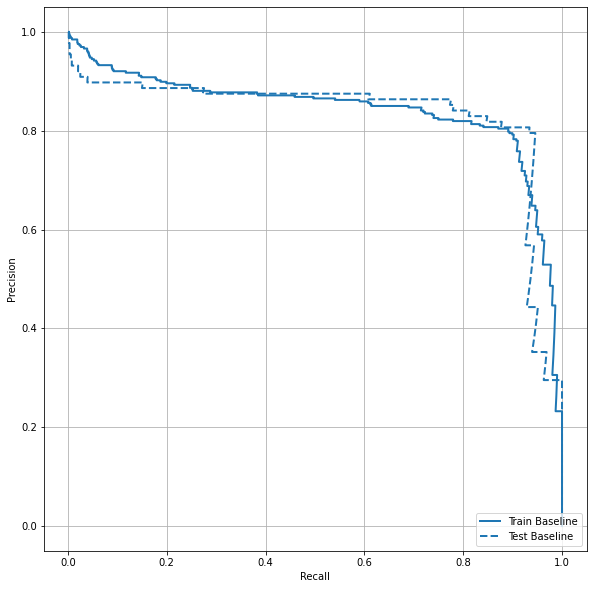

In [ ]:
# AUPRC
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
# calculate class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [ ]:
# train a model with class weights
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(train_features, train_labels, batch_size=BATCH_SIZE,
                                      epochs=EPOCHS, callbacks=[early_stopping],
                                      validation_data=(val_features, val_labels),
                                      class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 3s 15ms/step - loss: 2.2792 - tp: 121.0000 - fp: 1457.0000 - tn: 237366.0000 - fn: 294.0000 - accuracy: 0.9927 - precision: 0.0767 - recall: 0.2916 - auc: 0.7368 - prc: 0.0605 - val_loss: 0.0296 - val_tp: 35.0000 - val_fp: 231.0000 - val_tn: 45261.0000 - val_fn: 42.0000 - val_accuracy: 0.9940 - val_precision: 0.1316 - val_recall: 0.4545 - val_auc: 0.8841 - val_prc: 0.1763
Epoch 2/100
90/90 [==============================] - 0s 4ms/step - loss: 0.8004 - tp: 191.0000 - fp: 2722.0000 - tn: 179227.0000 - fn: 136.0000 - accuracy: 0.9843 - precision: 0.0656 - recall: 0.5841 - auc: 0.8845 - prc: 0.1448 - val_loss: 0.0416 - val_tp: 61.0000 - val_fp: 370.0000 - val_tn: 45122.0000 - val_fn: 16.0000 - val_accuracy: 0.9915 - val_precision: 0.1415 - val_recall: 0.7922 - val_auc: 0.9296 - val_prc: 0.3992
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 0.4848 - tp: 245.0000 - fp: 3835.0000 - tn: 178114.0000 - fn: 82.0000 - 

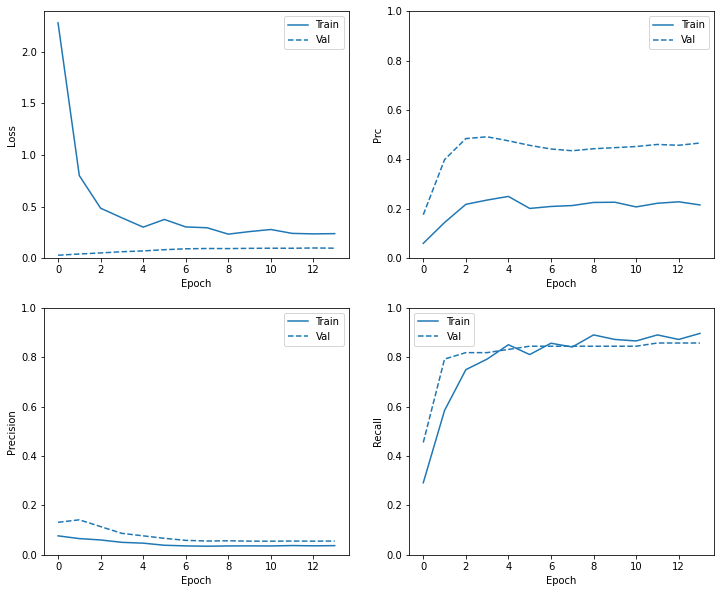

In [ ]:
# plot metrics
plot_metrics(weighted_history)

loss :  0.05848284065723419
tp :  79.0
fp :  821.0
tn :  56053.0
fn :  9.0
accuracy :  0.9854288697242737
precision :  0.08777777850627899
recall :  0.8977272510528564
auc :  0.9627276659011841
prc :  0.5873692631721497

Legitimate Transactions Detected (True Negatives):  56053
Legitimate Transactions Incorrectly Detected (False Positives):  821
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  79
Total Fraudulent Transactions:  88


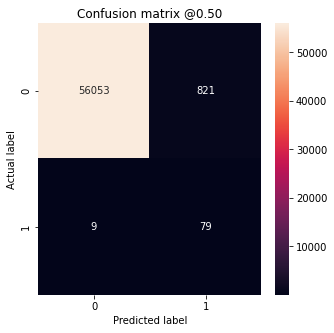

In [ ]:
# evaluate metrics
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

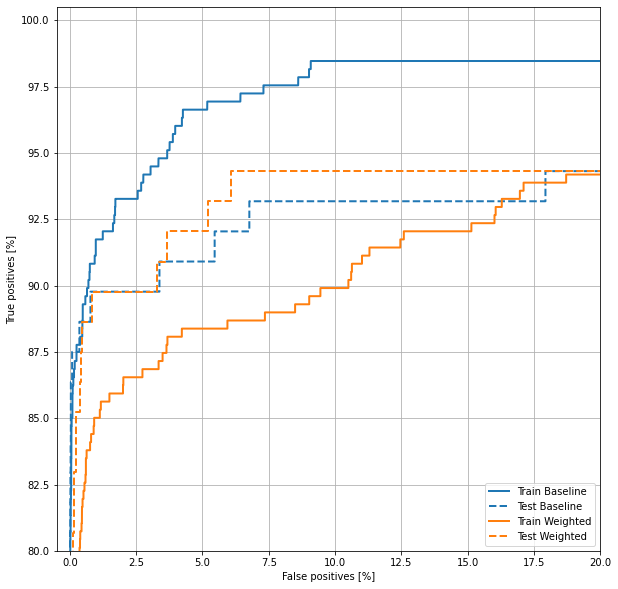

In [ ]:
# plot ROC
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

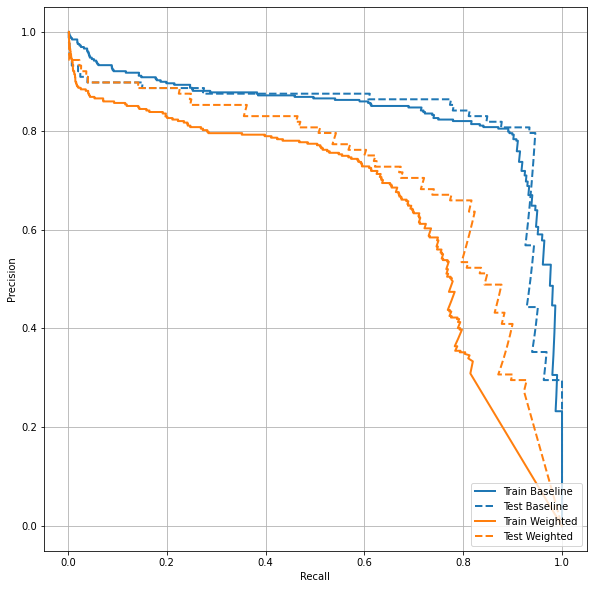

In [ ]:
# plot AUPRC
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
# oversampling
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181949, 29)

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363898, 29)

In [ ]:
# using tf.data
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
# each dataset provides (feature, label) pairs
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-5.          3.81822774 -5.          5.         -5.         -2.10226765
 -5.          5.         -5.         -5.          5.         -5.
  1.18819052 -5.         -0.45545789 -5.         -5.         -5.
  2.5839423  -1.31506801  2.91128001 -1.75350628 -0.05350811  1.01325757
  0.67035962 -0.8900211  -1.72746252 -2.48476735  1.0932068 ]

Label:  1


In [ ]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

Instructions for updating:
Use `tf.data.Dataset.random(...)`.
0.51123046875


In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [ ]:
# train on the oversampled data
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(resampled_ds, epochs=EPOCHS, 
                                        steps_per_epoch=resampled_steps_per_epoch,
                                        callbacks=[early_stopping], validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 21s 67ms/step - loss: 0.6015 - tp: 248963.0000 - fp: 159905.0000 - tn: 181321.0000 - fn: 36117.0000 - accuracy: 0.6870 - precision: 0.6089 - recall: 0.8733 - auc: 0.8634 - prc: 0.8839 - val_loss: 0.5553 - val_tp: 68.0000 - val_fp: 6300.0000 - val_tn: 39192.0000 - val_fn: 9.0000 - val_accuracy: 0.8616 - val_precision: 0.0107 - val_recall: 0.8831 - val_auc: 0.9378 - val_prc: 0.6507
Epoch 2/100
278/278 [==============================] - 17s 63ms/step - loss: 0.3101 - tp: 259085.0000 - fp: 26797.0000 - tn: 258228.0000 - fn: 25234.0000 - accuracy: 0.9086 - precision: 0.9063 - recall: 0.9112 - auc: 0.9536 - prc: 0.9687 - val_loss: 0.3491 - val_tp: 66.0000 - val_fp: 1256.0000 - val_tn: 44236.0000 - val_fn: 11.0000 - val_accuracy: 0.9722 - val_precision: 0.0499 - val_recall: 0.8571 - val_auc: 0.9599 - val_prc: 0.7004
Epoch 3/100
278/278 [==============================] - 18s 63ms/step - loss: 0.2344 - tp: 260724.0000 - fp: 10679.0000 - tn:

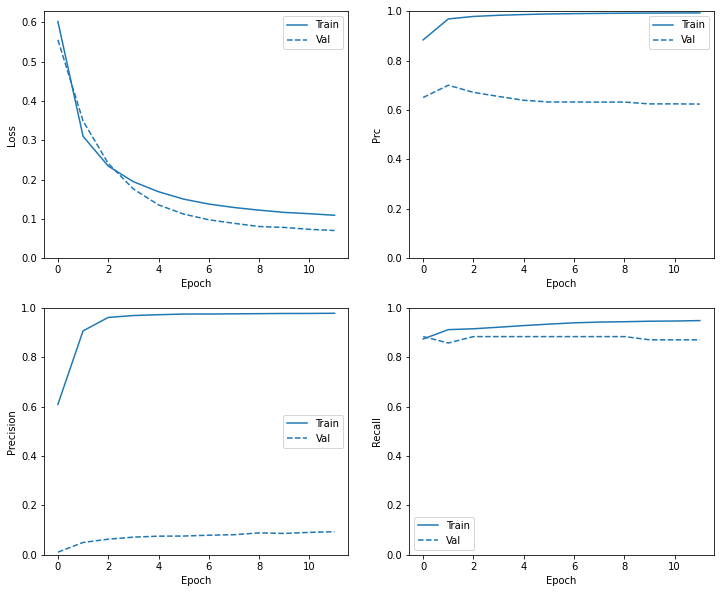

In [ ]:
# training history
plot_metrics(resampled_history)

In [ ]:
# re-train
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(resampled_ds, steps_per_epoch=20, epochs=10*EPOCHS,
                                        callbacks=[early_stopping], validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 5s 121ms/step - loss: 1.3265 - tp: 11555.0000 - fp: 17854.0000 - tn: 48304.0000 - fn: 8816.0000 - accuracy: 0.6918 - precision: 0.3929 - recall: 0.5672 - auc: 0.7486 - prc: 0.4952 - val_loss: 1.3063 - val_tp: 54.0000 - val_fp: 41121.0000 - val_tn: 4371.0000 - val_fn: 23.0000 - val_accuracy: 0.0971 - val_precision: 0.0013 - val_recall: 0.7013 - val_auc: 0.5188 - val_prc: 0.0065
Epoch 2/1000
20/20 [==============================] - 1s 68ms/step - loss: 0.9400 - tp: 15546.0000 - fp: 16897.0000 - tn: 3522.0000 - fn: 4995.0000 - accuracy: 0.4655 - precision: 0.4792 - recall: 0.7568 - auc: 0.6210 - prc: 0.7147 - val_loss: 1.2231 - val_tp: 73.0000 - val_fp: 40481.0000 - val_tn: 5011.0000 - val_fn: 4.0000 - val_accuracy: 0.1116 - val_precision: 0.0018 - val_recall: 0.9481 - val_auc: 0.7665 - val_prc: 0.0448
Epoch 3/1000
20/20 [==============================] - 1s 76ms/step - loss: 0.7781 - tp: 17438.0000 - fp: 16606.0000 - tn: 3989.0000 - f

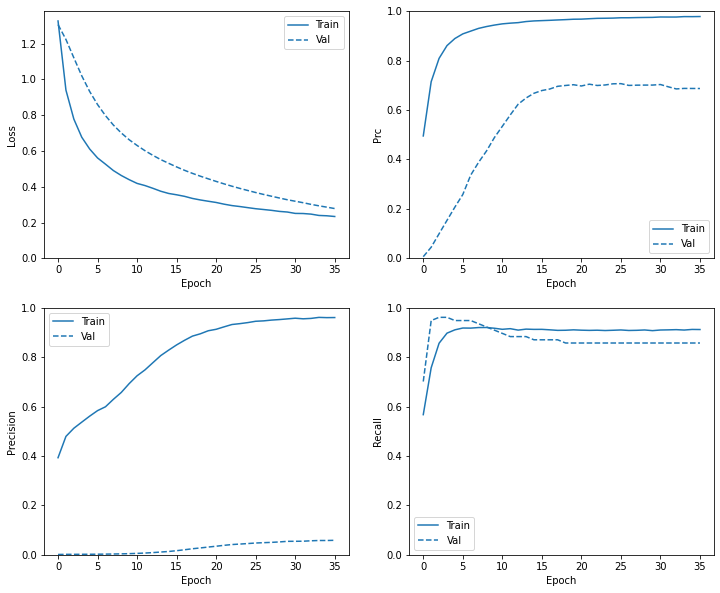

In [ ]:
plot_metrics(resampled_history)

loss :  0.36657318472862244
tp :  81.0
fp :  1591.0
tn :  55283.0
fn :  7.0
accuracy :  0.9719462394714355
precision :  0.048444975167512894
recall :  0.9204545617103577
auc :  0.9658845663070679
prc :  0.8045873641967773

Legitimate Transactions Detected (True Negatives):  55283
Legitimate Transactions Incorrectly Detected (False Positives):  1591
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  81
Total Fraudulent Transactions:  88


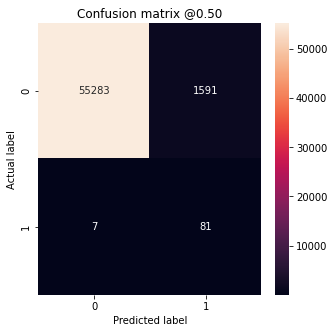

In [ ]:
# evaluate metrics
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

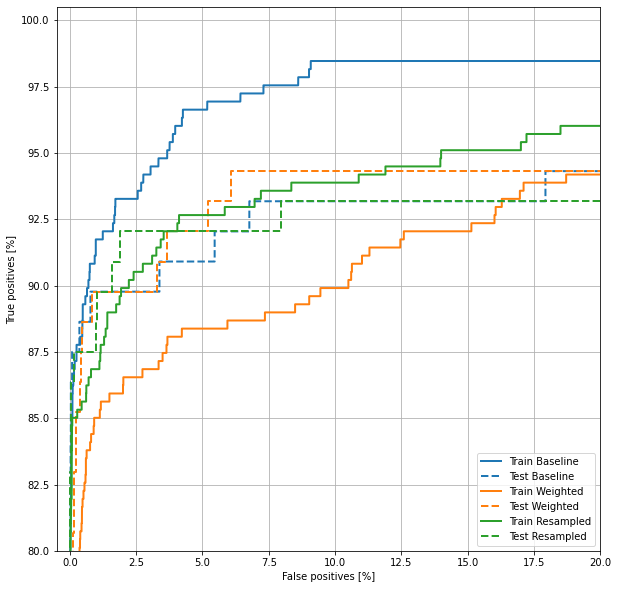

In [ ]:
# ROC
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

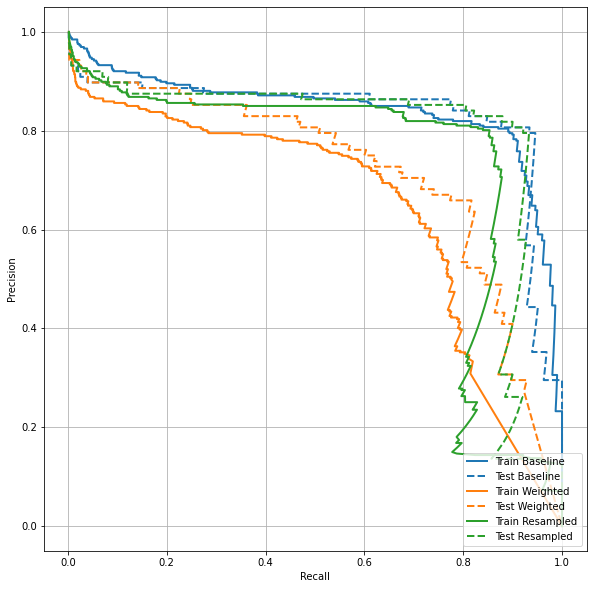

In [ ]:
# AUPRC
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')